This notebook contains code found in the AWS docs: https://docs.aws.amazon.com/rekognition/latest/dg/faces.html

In [1]:
from ipynb.fs.full.utils import *

In [2]:
def detect_faces_api(photo, bucket, local=False, grey=False):
    client=boto3.client('rekognition')
    try:
        if local:
            with open("../images/" + photo, 'rb') as img_file:
                img = Image.open(io.BytesIO(img_file.read()))
                img.show()
                w, h = img.size

                if w < 80 or h < 80:
                    raise Exception("Image {} too small: ({},{}).Each dimension should at least be 80 pixels".format(photo, w, h))

                if grey:
                    gray_image = ImageOps.grayscale(img)
                    gray_image.save(photo)
            
            with open("images/" + photo, 'rb') as img_file:
                response = client.detect_faces(Image={'Bytes': img_file.read()})
        else:
            response = client.detect_faces(
                Image={'S3Object':{'Bucket':bucket,'Name':photo}},
                Attributes=['ALL']
            )
    except Exception as e:
        print('Couldn\'t detect faces in {}: {}.'.format(photo, repr(e)))
        raise
    else:
        return {'face_details': response['FaceDetails'], 'face_count': len(response['FaceDetails'])}

In [3]:
def detect_faces(photos, bucket, local, grey=False):
    for photo in photos:
        try:
            # download and save the image from the bucket so we can display it
            obj=get_object(bucket, photo, "../images/" + photo)
            with open("../images/" + photo, 'rb') as img_file:
                photo_bytes = img_file.read()


            faces=detect_faces_api(photo, bucket, local, grey)
            colors = ['aqua']*faces['face_count']
            bounding_boxes = []

            # gather the bounding boxes so we can easily access them 
            for face in faces['face_details']:
                print(face)
                bounding_boxes.append(face['BoundingBox'])


            show_bounding_boxes(photo_bytes, bounding_boxes, colors)
        except Exception as e:
            print(repr(e))

In [4]:
def detect_faces_cropped(photos, bucket):
    for photo in photos:
        try:
            # download and save the image from the bucket so we can display it
            obj = get_object(bucket, photo, "../images/" + photo)
            with open("../images/" + photo, 'rb') as img_file:
                photo_bytes = img_file.read()

            faces = detect_faces_api(photo, bucket)

            bounding_boxes = []
            for face in faces['face_details']:
                bounding_boxes.append(face['BoundingBox'])

            cropped_photos = crop_bounding_boxes(photo, photo_bytes, bounding_boxes)
        except Exception as e:
            print(repr(e))

In [5]:
def detect_face_attributes(photos, bucket, local):
    for photo in photos:
        try:
            # download and save the image from the bucket so we can display it
            obj = get_object(bucket, photo, "../images/" + photo)
            with open("../images/" + photo, 'rb') as img_file:
                photo_bytes = img_file.read()

            faces = detect_faces_api(photo, bucket, local)

            colors = ['aqua']*faces['face_count']
            bounding_boxes = []
            labels = []
            for face in faces['face_details']:
                bounding_boxes.append(face['BoundingBox'])
                
                highest_confidence_emotion = None
                highest_confidence = 0.0
                for emotion in face['Emotions']:
                    if emotion['Confidence'] > highest_confidence:
                        highest_confidence = emotion['Confidence']
                        highest_confidence_emotion = emotion ['Type']
                
                label= """Age Range: {}\nGender: {}\nSmile: {}\nEmotion: {}
                   """.format(
                       face['AgeRange'], 
                       "{} - {}".format(face['Gender']['Value'], face['Gender']['Confidence']),
                       "{} - {}".format(face['Smile']['Value'], face['Smile']['Confidence']),
                       "{} - {}".format(highest_confidence_emotion, highest_confidence))
                
                labels.append([
                  label,
                  "Bottom", 
                  "Left"])                        
                # labels.append(["{}, {}".format(highest_confidence_emotion, highest_confidence), "Top", "Left"])
            show_bounding_boxes(
                photo_bytes, 
                bounding_boxes, 
                colors, 
                labels = labels,
                # fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", 12),
                fnt = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf", 12),
                
                text_fill=(0,255,255,128)
            )
        except Exception as e:
            print(repr(e))

In [13]:
def test_detect_faces(local):
    photos=['crowd.jpeg', 'trump.jpg']
    bucket='labs-rekognition-demo-bucket'
    detect_faces(photos, bucket, local)

In [7]:
def test_detect_faces_attributes(local):
    photos=['hackerman.png']
    bucket='labs-rekognition-demo-bucket'
    detect_face_attributes(photos, bucket, local)

In [8]:
def test_detect_faces_cropped():
    photos=['avengers_cast.jpg']
    bucket='labs-rekognition-demo-bucket'
    detect_faces_cropped(photos, bucket)


{'BoundingBox': {'Width': 0.18384374678134918, 'Height': 0.40477123856544495, 'Left': 0.7792018055915833, 'Top': 0.5035472512245178}, 'AgeRange': {'Low': 22, 'High': 34}, 'Smile': {'Value': False, 'Confidence': 62.507568359375}, 'Eyeglasses': {'Value': False, 'Confidence': 99.7916488647461}, 'Sunglasses': {'Value': False, 'Confidence': 99.92730712890625}, 'Gender': {'Value': 'Male', 'Confidence': 99.00982666015625}, 'Beard': {'Value': False, 'Confidence': 53.808570861816406}, 'Mustache': {'Value': False, 'Confidence': 93.99816131591797}, 'EyesOpen': {'Value': False, 'Confidence': 53.669593811035156}, 'MouthOpen': {'Value': True, 'Confidence': 72.82689666748047}, 'Emotions': [{'Type': 'HAPPY', 'Confidence': 36.3737907409668}, {'Type': 'CALM', 'Confidence': 26.249515533447266}, {'Type': 'ANGRY', 'Confidence': 14.22546672821045}, {'Type': 'SURPRISED', 'Confidence': 8.503159523010254}, {'Type': 'FEAR', 'Confidence': 8.193744659423828}, {'Type': 'CONFUSED', 'Confidence': 2.258478879928589},

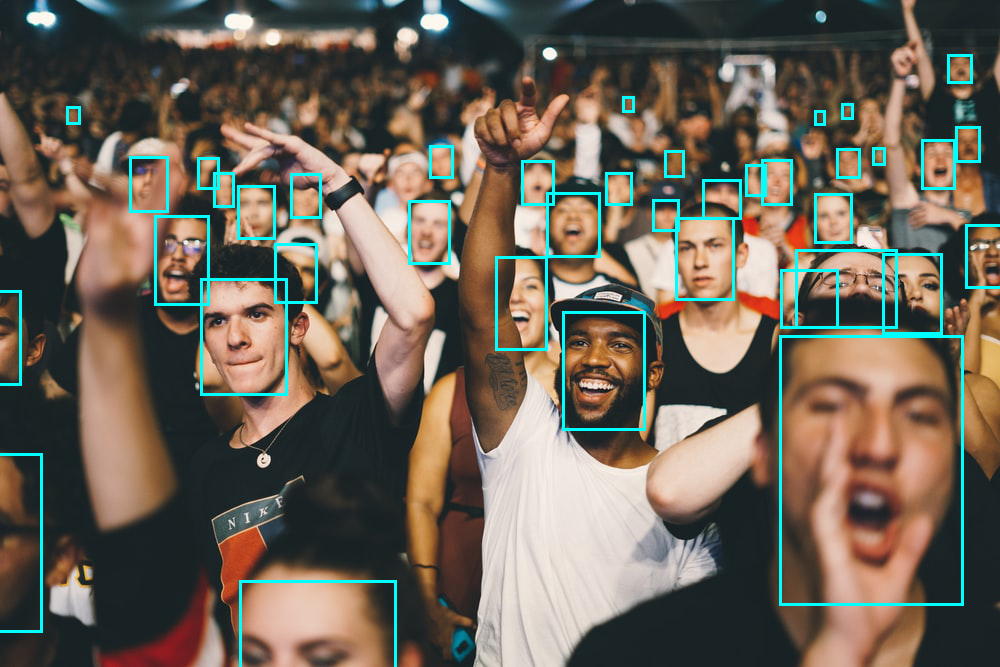

{'BoundingBox': {'Width': 0.17530295252799988, 'Height': 0.36864519119262695, 'Left': 0.3409395217895508, 'Top': 0.18004266917705536}, 'AgeRange': {'Low': 20, 'High': 32}, 'Smile': {'Value': False, 'Confidence': 98.26919555664062}, 'Eyeglasses': {'Value': False, 'Confidence': 87.53034973144531}, 'Sunglasses': {'Value': False, 'Confidence': 94.7860336303711}, 'Gender': {'Value': 'Female', 'Confidence': 64.74765014648438}, 'Beard': {'Value': False, 'Confidence': 91.57279205322266}, 'Mustache': {'Value': False, 'Confidence': 98.10581970214844}, 'EyesOpen': {'Value': True, 'Confidence': 94.0556411743164}, 'MouthOpen': {'Value': False, 'Confidence': 88.91706848144531}, 'Emotions': [{'Type': 'CALM', 'Confidence': 98.28459930419922}, {'Type': 'FEAR', 'Confidence': 0.8524906039237976}, {'Type': 'SAD', 'Confidence': 0.2352832406759262}, {'Type': 'HAPPY', 'Confidence': 0.2040690779685974}, {'Type': 'SURPRISED', 'Confidence': 0.1658971756696701}, {'Type': 'ANGRY', 'Confidence': 0.1073244512081146

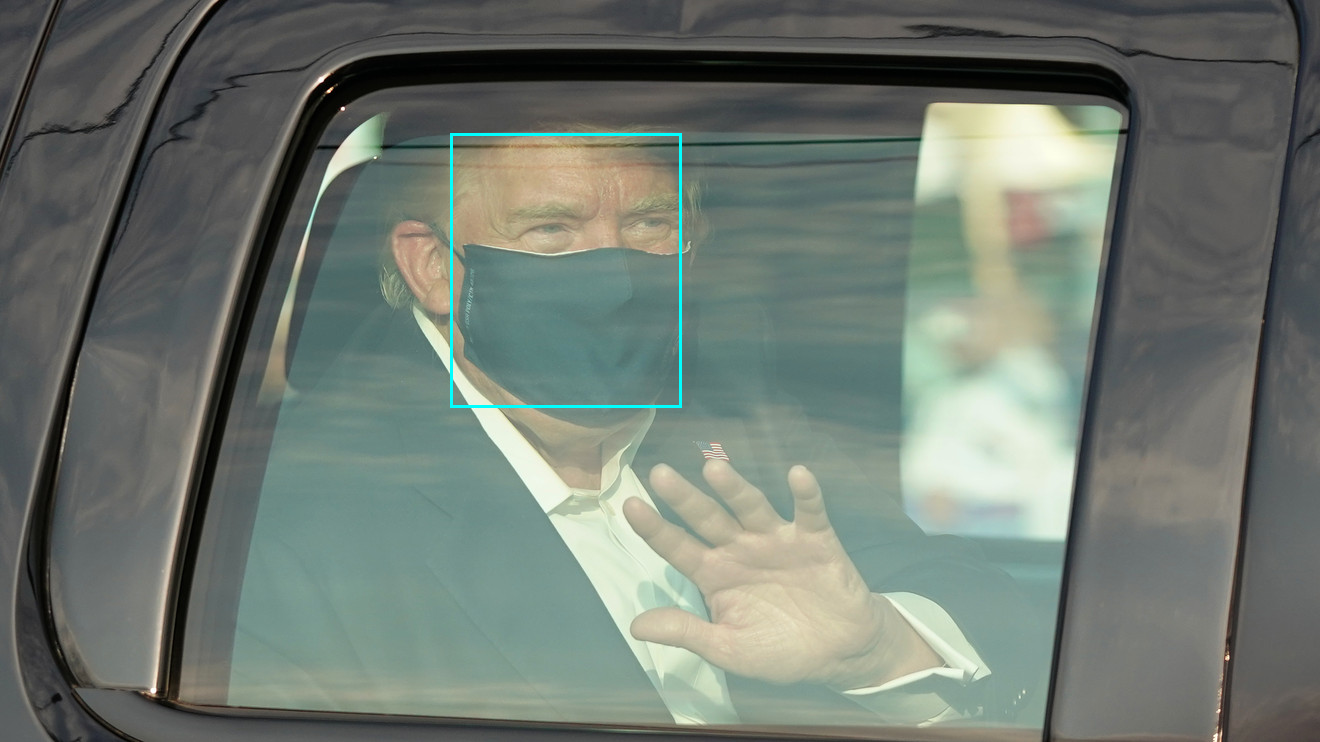

In [14]:
test_detect_faces(False)

In [10]:
test_detect_faces_cropped()

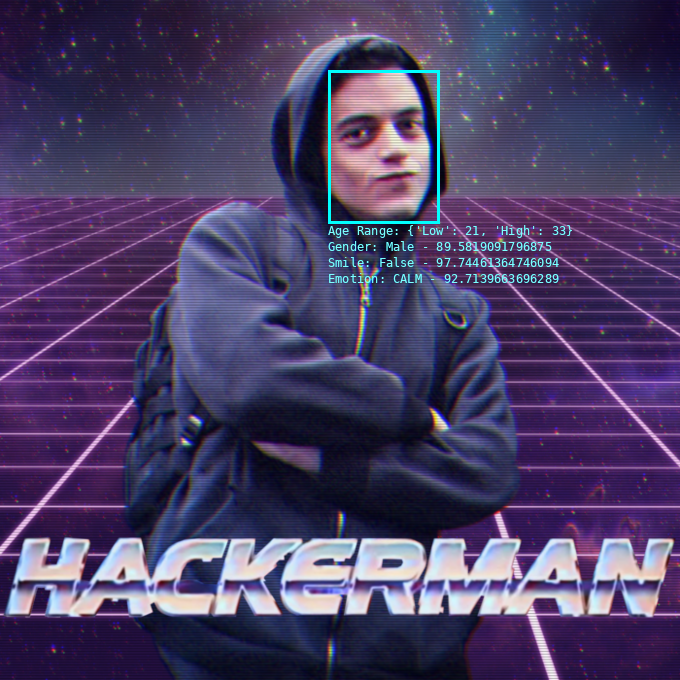

In [11]:
test_detect_faces_attributes(False)